In [39]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.models import load_model


from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.io import imread, imshow, imread_collection, concatenate_images

from keras import backend as K

seed = 42
IMG_HEIGHT = 160
IMG_WIDTH = 160

In [4]:
data_dir = '/Users/ivanalchuk/.keras/datasets/flower_photos'

In [5]:
labels = ["roses", "sunflowers", "tulips", "dandelion", "daisy"]

In [40]:
%%time
pictures =[]

for l in labels:
    for path in os.listdir(os.path.join(data_dir, l)):
        full_path = os.path.join(data_dir, l, path)
        img = imread(full_path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)                   
        pictures.append(img) 

CPU times: user 29.7 s, sys: 1.89 s, total: 31.6 s
Wall time: 37.4 s


In [41]:
pictures = np.array(pictures)
pictures = pictures.astype('float32') / 255.

In [42]:
pictures = pictures[:2000]
train, test = train_test_split(pictures, test_size = 10, random_state = seed)

In [44]:
train_grey = gray2rgb(rgb2gray(train))

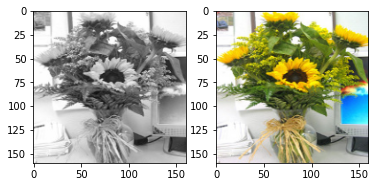

In [45]:
plt.subplot(1, 2, 1)
plt.imshow(train_grey[1])
plt.subplot(1, 2, 2)
plt.imshow(train[1])
plt.show()

In [46]:
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsampleп

In [47]:
def model():
    inputs = layers.Input(shape= [IMG_HEIGHT,IMG_WIDTH,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [48]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential_11 (Sequential)  (None, 80, 80, 128)          3584      ['input_3[0][0]']             
                                                                                                  
 sequential_12 (Sequential)  (None, 40, 40, 128)          147584    ['sequential_11[0][0]']       
                                                                                                  
 sequential_13 (Sequential)  (None, 20, 20, 256)          296192    ['sequential_12[0][0]']       
                                                                                              

In [52]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

hist = model.fit(train_grey, train, epochs = 50,batch_size = 50,verbose = 0)

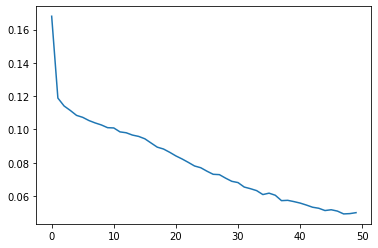

In [53]:
plt.plot(hist.history['loss'])

In [67]:
test_gray = gray2rgb(rgb2gray(test))

model.evaluate(test_gray,test)

1/1 [==============================] - 0s 272ms/step - loss: 0.0946 - acc: 0.5641


[0.09455321729183197, 0.5641210675239563]

1/1 [==============================] - 0s 24ms/step


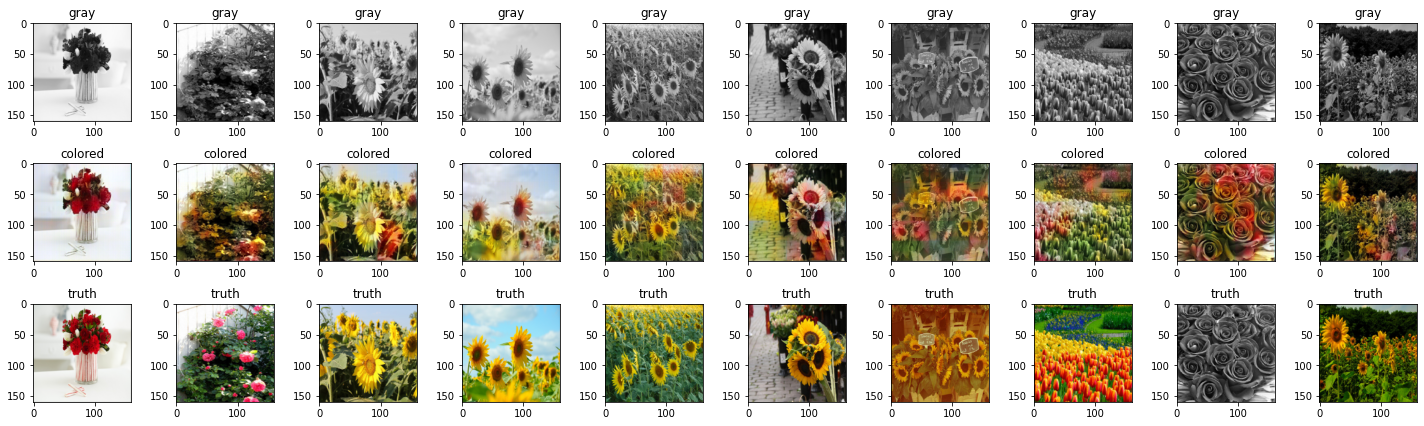

In [68]:
plt.figure(figsize=(20, 6))
for i, image in enumerate(test_gray):
    plt.subplot(3, 10, i + 1)
    colored  = np.clip(model.predict(image.reshape(1,160, 160,3)),0.0,1.0).reshape(160, 160,3)
    plt.imshow(image)
    plt.title('gray')
    
    plt.subplot(3, 10, i + 10 + 1)
    plt.imshow(colored)
    plt.title('colored')
    
    plt.subplot(3, 10, i + 20 + 1)
    plt.imshow(test[i])
    plt.title('truth')
    
plt.tight_layout()
    